### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b>. (train: 4,263 / test: 1,215)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcWlrJ2qjtRJtQVIwR1kW2EBTj8le3PdXI4TYsKErsGMcA?download=1 -O CelebA_HQ_facial_identity_dataset_test.zip
!unzip CelebA_HQ_facial_identity_dataset_test.zip -d ./CelebA_HQ_facial_identity_dataset_test

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [7]:
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_facial_identity_dataset_test'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', 

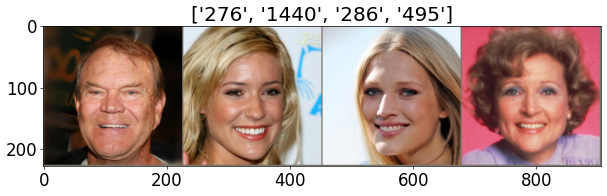

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [9]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYJeZpups5FEir_wwzkMw30Bq5ZFCA0SbC1UT7ATAwsYsA?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18.pth

--2021-03-12 15:33:19--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYJeZpups5FEir_wwzkMw30Bq5ZFCA0SbC1UT7ATAwsYsA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWUplWnB1cHM1RkVpcl93d3prTXczMEJxNVpGQ0EwU2JDMVVUN0FUQXdzWXNBP3J0aW1lPXQ0UkRLbXpsMkVn [following]
--2021-03-12 15:33:20--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0Z

In [10]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### <b>Test Phase</b>

[Prediction Result Examples]


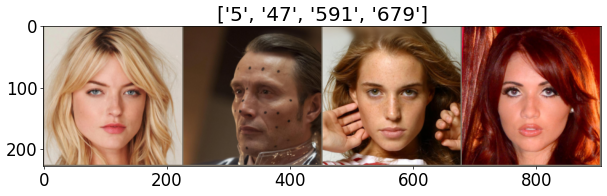

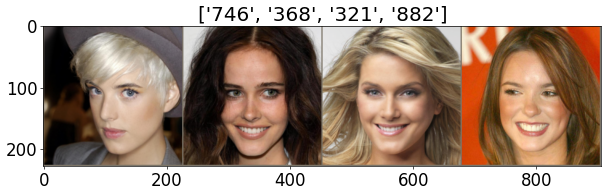

[Test] Loss: 0.5886 Acc: 86.0082% Time: 20.4765s


In [13]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))